In [1]:
import sys
print(sys.executable)  # Shows which Python the notebook is using

import imblearn
print(imblearn.__version__)  # Confirms imbalanced-learn is accessible

e:\Nihal\anaconda\python.exe
0.14.1


In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



In [3]:
# Download NLTK stopwords if they haven't been downloaded already
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load the dataset from a CSV file
df = pd.read_csv("spam.csv", encoding='latin-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(403)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(5169, 5)

In [10]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [11]:
# Define a function to manually preprocess the text messages
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase for uniformity
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove extra whitespace from the start and end
    words = text.split()  # Tokenize the text into words
    stop_words = set(stopwords.words('english'))  # Load stopwords
    stemmer = PorterStemmer()  # Initialize the stemmer
    # Remove stopwords and apply stemming to each word
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [12]:
df['clean_message'] = df['message'].apply(preprocess_text)

In [13]:
df['clean_message'][0]

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_message'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

In [15]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [16]:
smote = BorderlineSMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [17]:
print(f"Before SMOTE: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_train_resampled)}")

Before SMOTE: Counter({0: 3613, 1: 522})
After SMOTE: Counter({0: 3613, 1: 3613})


In [18]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss",max_depth=4, n_estimators=500, learning_rate=0.1, random_state=42,n_jobs=-1)
model_xgb.fit(X_train_resampled, y_train_resampled)

e:\Nihal\anaconda\Lib\site-packages\xgboost\training.py:200: UserWarning: [20:56:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [31]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,max_depth=10,min_samples_leaf=2)
model_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = model_rf.predict(X_test_tfidf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       903
           1       0.99      0.72      0.83       131

    accuracy                           0.96      1034
   macro avg       0.98      0.86      0.91      1034
weighted avg       0.96      0.96      0.96      1034



In [20]:
y_pred = model_xgb.predict(X_test_tfidf)

In [21]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       903
           1       0.91      0.84      0.87       131

    accuracy                           0.97      1034
   macro avg       0.94      0.91      0.93      1034
weighted avg       0.97      0.97      0.97      1034



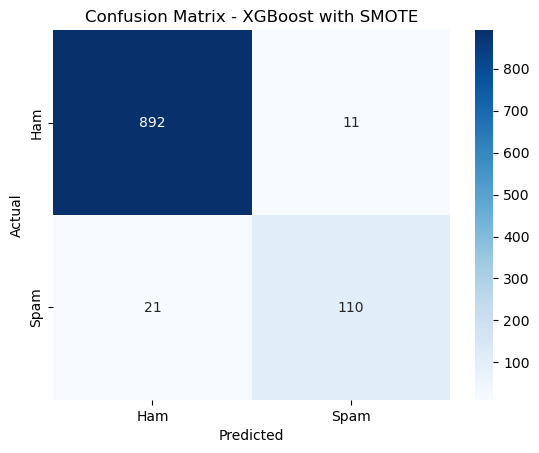

In [22]:
xgb_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost with SMOTE")
plt.show()
     

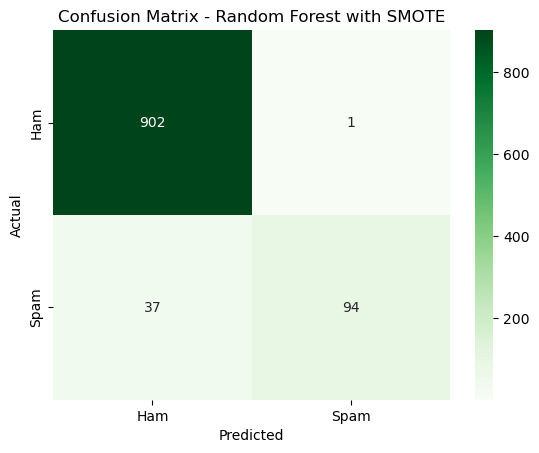

In [32]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="Greens", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()

In [33]:
def predict_spam(message,model_name):
    processed_message = preprocess_text(message)
    vec_message = vectorizer.transform([processed_message])
    if model_name == "rf":
        prediction = model_rf.predict(vec_message)
    elif model_name == "xgb":
        prediction = model_xgb.predict(vec_message)
    else:
        raise ValueError("Invalid model name")
    return "Spam" if prediction[0] == 1 else "Ham"


example_message = "hey, where r u? Dinner tonight?"
print("Prediction:", predict_spam(example_message,"rf"))

Prediction: Ham


In [41]:
print("Prediction:", predict_spam("Hey dinner tonight?","xgb"))

Prediction: Ham


In [42]:
print("Prediction:", predict_spam("You are a winner! Claim your free prize now!","xgb"))

Prediction: Spam


In [43]:
print("Prediction:", predict_spam("You are a winner! Claim your free prize now!","rf"))

Prediction: Spam
